# XAI - Water Quality in Brisbane


Research question: How can machine learning models predict Dissolved Oxygen levels in water, and what factors most influence these predictions?

## Read and clean dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/brisbane_water_quality.csv')

In [3]:
df.describe()

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
count,30894.000000,30874.000000,30893.000000,30309.000000,30086.000000,25730.000000,25550.000000,26594.000000,26370.000000,25145.000000,24944.000000,29810.000000,29586.0,26936.000000,26712.0,29527.000000,29303.0,28894.000000,28670.0
mean,16914.500000,16.799189,177.544711,2.782251,1020.006648,24.415394,1021.673973,6.815158,1020.488055,96.641207,1022.976668,8.063260,1020.0,31.003265,1020.0,47.927487,1020.0,3.941688,1020.0
std,8918.473945,13.168964,103.621786,1.859404,1.153049,3.494728,40.599400,0.620860,21.976218,8.108339,54.204781,0.091714,0.0,3.469102,0.0,5.155305,0.0,4.072715,0.0
min,1468.000000,0.000000,0.000000,0.100000,1020.000000,17.000000,1020.000000,3.030000,1020.000000,51.836000,1020.000000,7.309000,1020.0,0.057000,1020.0,0.021000,1020.0,0.335000,1020.0
25%,9191.250000,6.594250,86.314000,1.451000,1020.000000,21.292000,1020.000000,6.387000,1020.000000,92.226000,1020.000000,7.980000,1020.0,29.151000,1020.0,45.046000,1020.0,2.354250,1020.0
50%,16914.500000,13.390500,176.326000,2.371000,1020.000000,25.245500,1020.000000,6.814000,1020.000000,96.513000,1020.000000,8.073000,1020.0,30.603500,1020.0,47.420000,1020.0,3.093000,1020.0
75%,24637.750000,23.600000,267.870000,3.650000,1020.000000,27.254000,1020.000000,7.254000,1020.000000,101.668000,1020.000000,8.140000,1020.0,33.918000,1020.0,53.361000,1020.0,4.005000,1020.0
max,32361.000000,89.912000,359.994000,43.301000,1220.000000,32.063000,2010.000000,9.260000,2010.000000,134.082000,2010.000000,8.255000,1020.0,36.000000,1020.0,54.996000,1020.0,49.869000,1020.0


In [4]:
# [quality] columns contain metadata about the quality of the measurement. We however do not have access to what the specific codes actually mean.
# Therefore they have no use to us in this analysis, and we therefore drop them.

df = df.drop(columns=[col for col in df.columns if '[quality]' in col])


In [5]:
# Ensure that Timestamp column is of datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [6]:
# Set Timestamp as index
df = df.set_index('Timestamp')

In [7]:
# There are some timestamps where there are multiple measurements (duplicates). 
# We simply drop the duplicate measurements, using a "first wins" approach

print("Before removing duplicates: ", df.shape)

df = df[~df.index.duplicated(keep='first')]

print("After removing duplicates: ", df.shape)


Before removing duplicates:  (30894, 11)
After removing duplicates:  (30614, 11)


In [8]:
# All columns should now have the correct datatype (datetime timestamp, int record number, all other are floats)
df.dtypes

Record number                       int64
Average Water Speed               float64
Average Water Direction           float64
Chlorophyll                       float64
Temperature                       float64
Dissolved Oxygen                  float64
Dissolved Oxygen (%Saturation)    float64
pH                                float64
Salinity                          float64
Specific Conductance              float64
Turbidity                         float64
dtype: object

In [9]:
# For some measurements, the values are missing (nan).
print(f"Total number of rows: {df.shape[0]}")
print(f"Number of rows without any NaN values: {df.dropna().shape[0]}")

Total number of rows: 30614
Number of rows without any NaN values: 19212


In [10]:
# We have two strategies for handling missing (nan) values:
#   1. Drop the rows with missing data values (reducing records in dataset by around 1/3)
#   2. Use some technique to fill in missing data, like interpolation.
#       This is a common technique used in time series analysis to fill missing values in time series data. 

# We create dataframes with both strategies

df_drop = df.dropna()
df_interpolate = df.interpolate(method='time')

In [11]:
# Now all rows have values for all columns

print(f"Total number of rows (drop): {df_drop.shape[0]}")
print(f"Number of rows without any NaN values (drop): {df_drop.dropna().shape[0]}")

print(f"Total number of rows (interpolated): {df_interpolate.shape[0]}")
print(f"Number of rows without any NaN values (interpolated): {df_interpolate.dropna().shape[0]}")

Total number of rows (drop): 19212
Number of rows without any NaN values (drop): 19212
Total number of rows (interpolated): 30614
Number of rows without any NaN values (interpolated): 30614


In [12]:
# To simplify the code (avoiding having to passing around two dataframes, two sets of test data etc.),
#   we switch what dataframe we use, with a simple boolean flag. Results for both datasets are included in report.

USE_INTERPOLATED_DATAFRAME = True

df = df_interpolate if USE_INTERPOLATED_DATAFRAME else df_drop

In [13]:
# For some of the models (xgboost) we want to explore the impact of lag features
# We add 3 lag features for target 'Dissolved Oxygen', by shifting by 1, 2 and 3, respectively.

df['DO_lag1'] = df['Dissolved Oxygen'].shift(1)
df['DO_lag2'] = df['Dissolved Oxygen'].shift(2)
df['DO_lag3'] = df['Dissolved Oxygen'].shift(3)

# First 3 rows will not have complete data (NaN values for at least one of the lag features). 
# We simply drop these 3 rows

df = df.dropna()

print(f"Total number of rows: {df.shape[0]}")
print(f"Number of rows without any NaN values: {df.dropna().shape[0]}")



Total number of rows: 30611
Number of rows without any NaN values: 30611


## Exploratory Data Analysis

We do some exploratory data analysis (using the interpolated dataframe)

In [14]:
df

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity,DO_lag1,DO_lag2,DO_lag3
Timestamp,,,,,,,,,,,,,,
2023-08-05 00:30:00,1476,2.982,93.117,1.433,19.804,7.446,100.471,8.166,35.273,53.339,1.995,7.459,7.455,7.472
2023-08-05 01:00:00,1477,9.851,53.062,1.499,19.770,7.454,100.515,8.168,35.283,53.353,1.973,7.446,7.459,7.455
2023-08-05 01:30:00,1478,3.370,318.489,1.083,19.741,7.447,100.371,8.167,35.290,53.362,2.014,7.454,7.446,7.459
2023-08-05 02:00:00,1479,0.283,324.385,1.001,19.712,7.426,100.038,8.170,35.292,53.365,1.845,7.447,7.454,7.446
2023-08-05 02:30:00,1480,4.989,166.410,1.435,19.711,7.404,99.745,8.169,35.290,53.363,1.861,7.426,7.447,7.454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 08:20:00,32357,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963,6.796,7.155,7.004
2024-06-27 08:30:00,32358,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928,6.876,6.796,7.155
2024-06-27 08:40:00,32359,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097,6.918,6.876,6.796


### Plot oxygen levels, by time

In [15]:
# Create columns for each unique month, and day.

plot_df = df.copy()

plot_df['Year-Month'] = plot_df.index.to_period('M').astype(str)
plot_df['Year-Month-Day'] = plot_df.index.to_period('D').astype(str)

In [16]:
plot_df

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity,DO_lag1,DO_lag2,DO_lag3,Year-Month,Year-Month-Day
Timestamp,,,,,,,,,,,,,,,,
2023-08-05 00:30:00,1476,2.982,93.117,1.433,19.804,7.446,100.471,8.166,35.273,53.339,1.995,7.459,7.455,7.472,2023-08,2023-08-05
2023-08-05 01:00:00,1477,9.851,53.062,1.499,19.770,7.454,100.515,8.168,35.283,53.353,1.973,7.446,7.459,7.455,2023-08,2023-08-05
2023-08-05 01:30:00,1478,3.370,318.489,1.083,19.741,7.447,100.371,8.167,35.290,53.362,2.014,7.454,7.446,7.459,2023-08,2023-08-05
2023-08-05 02:00:00,1479,0.283,324.385,1.001,19.712,7.426,100.038,8.170,35.292,53.365,1.845,7.447,7.454,7.446,2023-08,2023-08-05
2023-08-05 02:30:00,1480,4.989,166.410,1.435,19.711,7.404,99.745,8.169,35.290,53.363,1.861,7.426,7.447,7.454,2023-08,2023-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 08:20:00,32357,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963,6.796,7.155,7.004,2024-06,2024-06-27
2024-06-27 08:30:00,32358,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928,6.876,6.796,7.155,2024-06,2024-06-27
2024-06-27 08:40:00,32359,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097,6.918,6.876,6.796,2024-06,2024-06-27


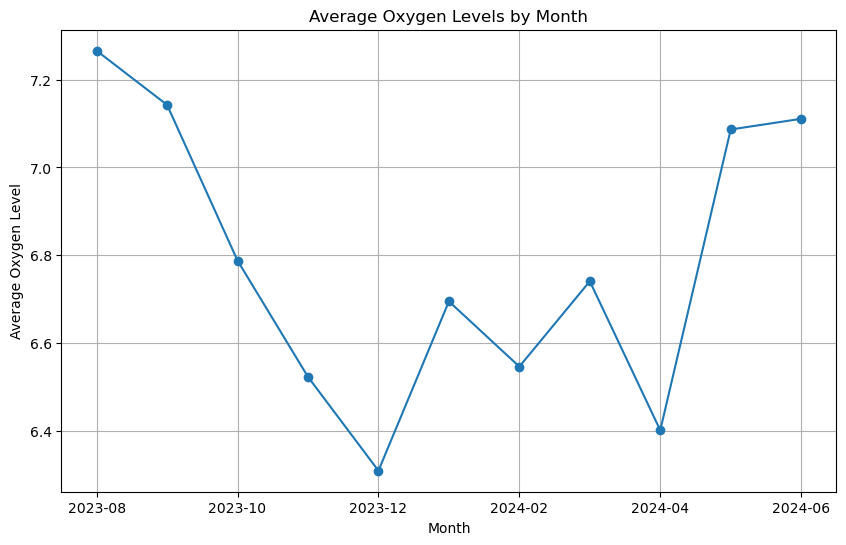

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by month and calculate the mean Dissolved Oxygen for each month
monthly_oxygen_levels = plot_df.groupby('Year-Month')['Dissolved Oxygen'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
monthly_oxygen_levels.plot(kind='line', marker='o')
plt.title('Average Oxygen Levels by Month')
plt.xlabel('Month')
plt.ylabel('Average Oxygen Level')
plt.grid(True)
plt.show()

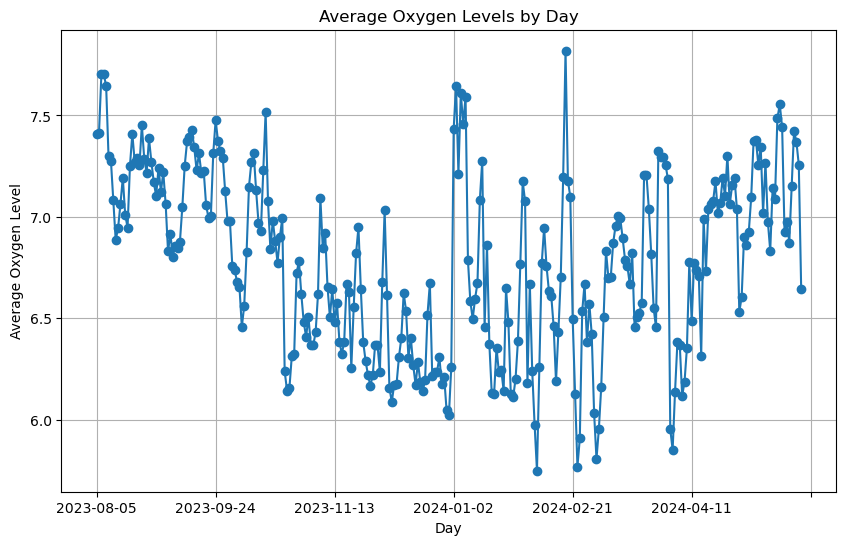

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by day and calculate the mean Dissolved Oxygen for each day
daily_oxygen_levels = plot_df.groupby('Year-Month-Day')['Dissolved Oxygen'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
daily_oxygen_levels.plot(kind='line', marker='o')
plt.title('Average Oxygen Levels by Day')
plt.xlabel('Day')
plt.ylabel('Average Oxygen Level')
plt.grid(True)
plt.show()

### Features correlated with oxygen

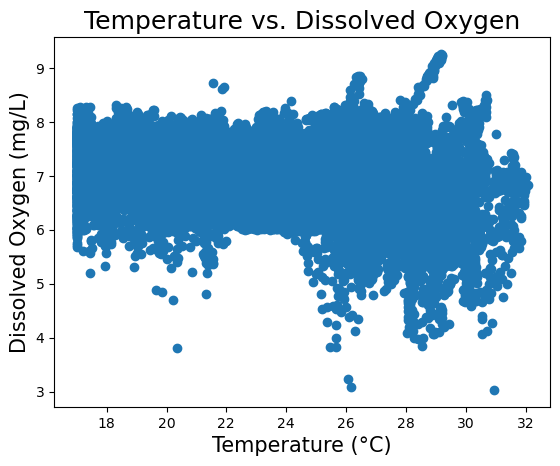

In [19]:
#plot 1: How tamperature affects Dissolved Oxygen
plt.scatter(df['Temperature'], df['Dissolved Oxygen'])
plt.xlabel ('Temperature (°C)', size=15)
plt.ylabel ('Dissolved Oxygen (mg/L)', size=15)
plt.title ('Temperature vs. Dissolved Oxygen', size=18)
plt.show()

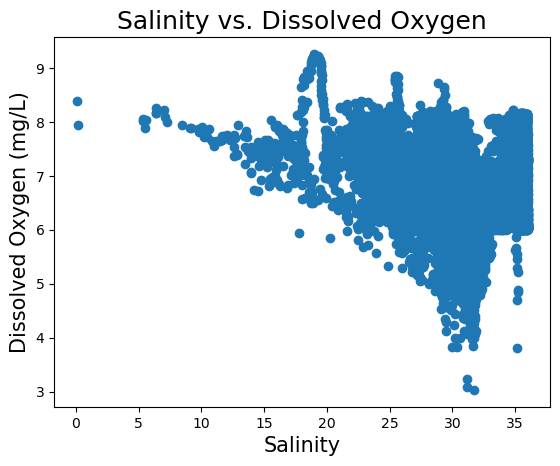

In [20]:
plt.scatter(df['Salinity'], df['Dissolved Oxygen'])
plt.xlabel ('Salinity', size =15)
plt.ylabel('Dissolved Oxygen (mg/L)', size=15)
plt.title ('Salinity vs. Dissolved Oxygen', size=18)
plt.show()

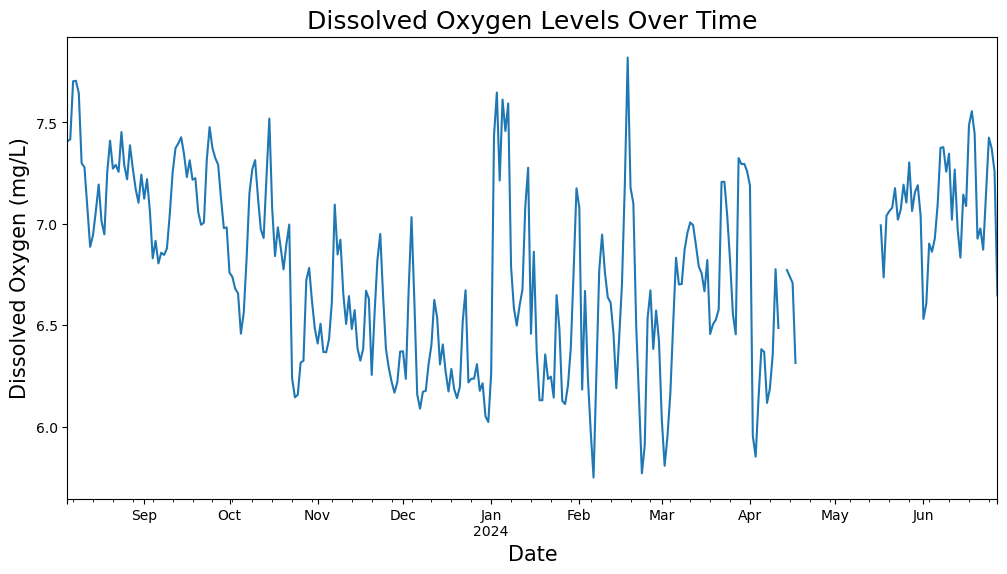

In [21]:
df.resample('D').mean()['Dissolved Oxygen'].plot(figsize=(12,6))
plt.xlabel('Date', size=15)
plt.ylabel('Dissolved Oxygen (mg/L)', size=15)
plt.title('Dissolved Oxygen Levels Over Time', size=18)
plt.show()

### Correlation Matrix

In order to investigate how different features of the dataset relates eachother, we can create a correlation matrix.

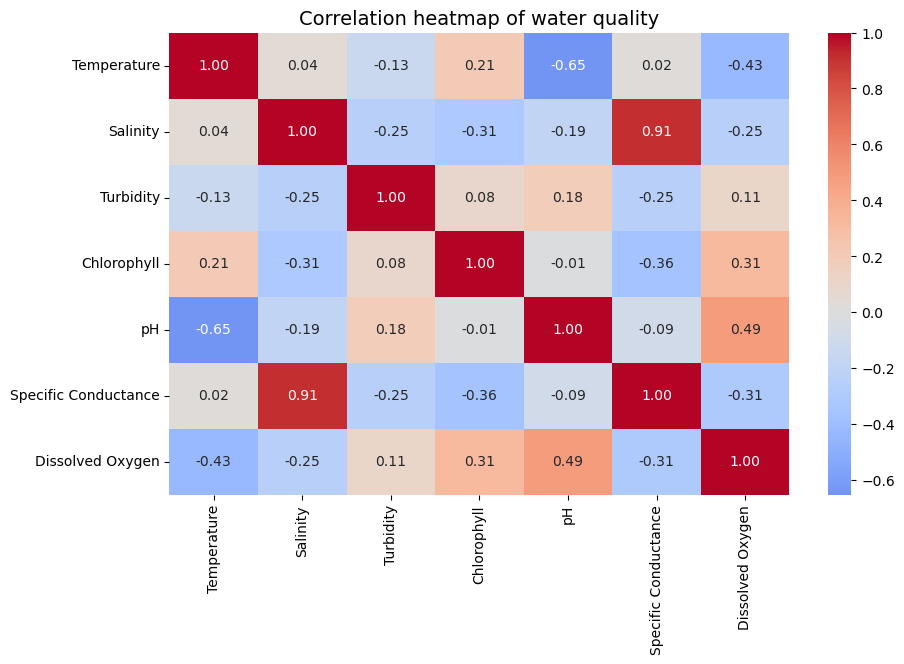

In [22]:
import seaborn as sns

features =[ "Temperature", "Salinity", "Turbidity", "Chlorophyll", "pH", "Specific Conductance", "Dissolved Oxygen" ]

correlation_matrix = df[features].corr()

#Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation heatmap of water quality", fontsize=14)
plt.show()

A positive correlation (closer to +1), that indicates the one feature increases, the other increases. For example

While the negative correlation (closer to -1) means that as one feature increases, the other decreases. For instance, higher tempratures is likely reduced dissolved oxygen levels.

A correlation close to 0 suggest that it is a weak or no relashionship between the features, meaning that changes in one feture do not significantly affect the other.

## Model

1. 2/ Autoregressive Integrated Moving Average (ARIMA)- mest kjent
2. Seasonal Autoregressive Integrated Moving-Average (SARIMA)
3. 3/ Long Short-Term Memory (LSTM): Long Short-Term Memory (LSTM) is a type of recurrent neural network that can learn the order dependence between items in a sequence. It is often used to solve time series forecasting problems.

Forecasting evaluation involves metrics like scale-dependent errors such as Mean squared error(MSE) and Root mean squared error (RMSE), Percentage errors such as Mean absolute percentage error (MAPE), Scaled errors such as Mean absolute scaled error (MASE) to mention a few. These metrics are actually similar to static ML metrics. 

In [23]:
from sklearn.model_selection import train_test_split

# X are features. 
# We remove Dissolved Oxygen (target) and Dissolved Oxygen (%Saturation), as it is a derived value.
# We also remove RecordNumber as it is just an index.

X = df.drop(columns=['Dissolved Oxygen', 'Dissolved Oxygen (%Saturation)', 'Record number'])
# Y are the target value - we want to predict amount of Dissolved Oxygen
y = df['Dissolved Oxygen']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We want to only allow xgboost model to access the lag features
X_train_xgb, X_test_xgb = X_train, X_test

X_train = X_train.drop(columns = ['DO_lag1', 'DO_lag2', 'DO_lag3'])
X_test = X_test.drop(columns = ['DO_lag1', 'DO_lag2', 'DO_lag3'])

#### Linear Regression

In [24]:
from sklearn.linear_model  import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

#### Random Forest Regressor

In [25]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### XGBoost

In [26]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train_xgb, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

#### Neural Network - LSTM(RNN)

In [27]:
# We suspected that LSTM neural network will only work well using input in chronological order - therefore having to avoid shuffling the data

# We therefore tried using a chronologically sorted training and test set - splitting manually on 80%. 

# This however did not improve the performance of the model - it also negatively impacted the results of the other models.

# split_index = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
# y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Constants for training of model

SEQUENCE_LENGTH = 48

HIDDEN_SIZE = 64  # Number of features in the hidden state
NUM_LAYERS = 2  # Number of LSTM layers

NUM_EPOCHS = 50

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Structure as 3D tensors for LSTM input
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])  # Sequence of `sequence_length` time steps
        y.append(target[i + sequence_length])   # Target is the next value
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.to_numpy(), SEQUENCE_LENGTH)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.to_numpy(), SEQUENCE_LENGTH)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32).view(-1, 1)  # Reshape for compatibility
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32).view(-1, 1)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for regression

    def forward(self, x):
        # Forward propagate through LSTM
        x, _ = self.lstm(x)  # No need to unsqueeze, input should already be 3D

        # unpack
        x = x[:, -1, :]

        # Pass the last time step's output to the fully connected layer
        x = self.fc(x)

        return x
    
    # Add a predict method
    def predict(self, X):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            X_seq, _ = create_sequences(X.to_numpy(), np.zeros(len(X)), SEQUENCE_LENGTH)
            X_tensor = torch.tensor(X_seq, dtype=torch.float32)  # Convert input to tensor
            predictions = self(X_tensor)  # Forward pass
        return predictions.numpy()  # Convert predictions to NumPy array


# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model_lstm = LSTMNetwork(input_size, HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# Train the model
for epoch in range(NUM_EPOCHS):
    model_lstm.train()
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model_lstm(batch_X)
        loss = criterion(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for every epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}")

# Evaluate the model on the test set
model_lstm.eval()
with torch.no_grad():
    test_predictions = model_lstm(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

Epoch 1/50, Loss: 0.41636207699775696
Epoch 2/50, Loss: 0.39836278557777405
Epoch 3/50, Loss: 0.41081702709198
Epoch 4/50, Loss: 0.4576672315597534
Epoch 5/50, Loss: 0.4248751103878021
Epoch 6/50, Loss: 0.4368537366390228
Epoch 7/50, Loss: 0.4549945890903473
Epoch 8/50, Loss: 0.5516815781593323
Epoch 9/50, Loss: 0.27936244010925293
Epoch 10/50, Loss: 0.23579280078411102
Epoch 11/50, Loss: 0.22929514944553375
Epoch 12/50, Loss: 0.47593948245048523
Epoch 13/50, Loss: 0.7666876912117004
Epoch 14/50, Loss: 0.3103191554546356
Epoch 15/50, Loss: 0.33447420597076416
Epoch 16/50, Loss: 0.4736282527446747
Epoch 17/50, Loss: 0.40303537249565125
Epoch 18/50, Loss: 0.6451811194419861
Epoch 19/50, Loss: 0.6094613671302795
Epoch 20/50, Loss: 0.45469534397125244
Epoch 21/50, Loss: 0.4439941346645355
Epoch 22/50, Loss: 0.2969517409801483
Epoch 23/50, Loss: 0.25937405228614807
Epoch 24/50, Loss: 0.33564209938049316
Epoch 25/50, Loss: 0.40081140398979187
Epoch 26/50, Loss: 0.5082499980926514
Epoch 27/50

## Evalute model against test data

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error


def eval_model(model, X=None, trim_sequence_length=False):
    X = X if X is not None else X_test
    
    # Make predictions on the test set
    y_pred = model.predict(X)

    y = y_test if not trim_sequence_length else y_test[SEQUENCE_LENGTH:] 

    # Calculate Mean Absolute Error (MAE)
    r2 = r2_score(y, y_pred)
    print(f'R2 score: {r2}')

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, y_pred)
    print(f'Mean Absolute Error: {mae}')

    # Calculate Root Squared Error (MSE)
    rmse = root_mean_squared_error(y, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    
    return {
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    
   

In [30]:
results = {}

In [31]:
results["Linear Regression"] = eval_model(model_lr)

R2 score: 0.45529338949078735
Mean Absolute Error: 0.3541274187243538
Root Mean Squared Error: 0.46979488718619095


In [32]:
results["Random Forest"] = eval_model(model_rfr)

R2 score: 0.8779160488902996
Mean Absolute Error: 0.1462113101855349
Root Mean Squared Error: 0.22241099408477805


In [33]:
results["XGBoost"] = eval_model(model_xgb, X=X_test_xgb)

R2 score: 0.9348050612616271
Mean Absolute Error: 0.10008225819549844
Root Mean Squared Error: 0.16253013790845025


In [34]:
results["LSTM"] = eval_model(model_lstm, trim_sequence_length=True)

R2 score: -0.667528530629061
Mean Absolute Error: 0.6415438225821262
Root Mean Squared Error: 0.8218493896347078


In [35]:
# Create DataFrame from results
results_df = pd.DataFrame.from_dict(results, orient='index')  # Transpose so models are rows
results_df = results_df.round(4)  # Round for readability

print(results_df)

                       R²     MAE    RMSE
Linear Regression  0.4553  0.3541  0.4698
Random Forest      0.8779  0.1462  0.2224
XGBoost            0.9348  0.1001  0.1625
LSTM              -0.6675  0.6415  0.8218


## XAI Methods

In [36]:
import shap
shap.initjs()

#### ***Linear Regression and SHAP***

In [37]:
#We use SHAP's Linear Explainer for our Linear Regression model
#because it's specifically designed to work with linear models.
 
explainer = shap.Explainer(model_lr, X_train) #Dont need to specify the explainer, since the new SHAP API does it automatically 
shap_values = explainer(X_test)

##### Global Plots

In [38]:
#Global Force plot

sample = shap.utils.sample(shap_values,1000,random_state=1)
shap.plots.force(sample)

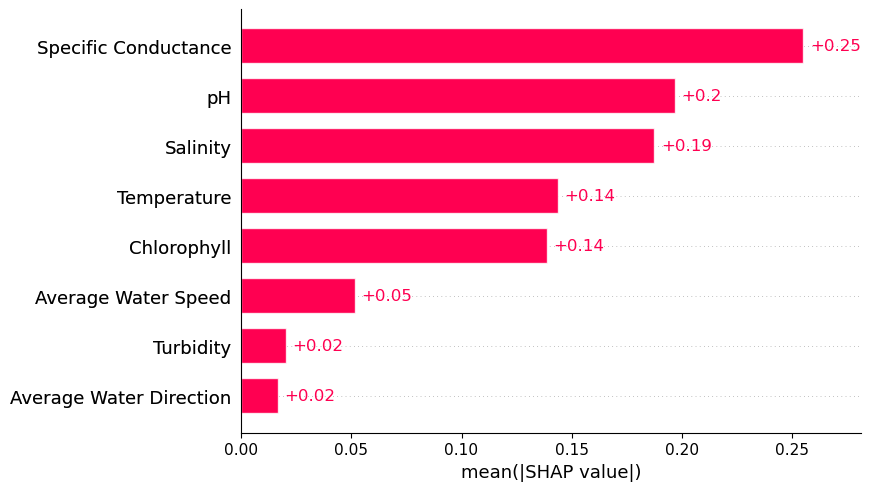

In [39]:
#Bar 
shap.plots.bar(shap_values)

The SHAP bar plot above only shows how much a feature contributes on average (the magnitude), but not the direction (increase or decrease). 

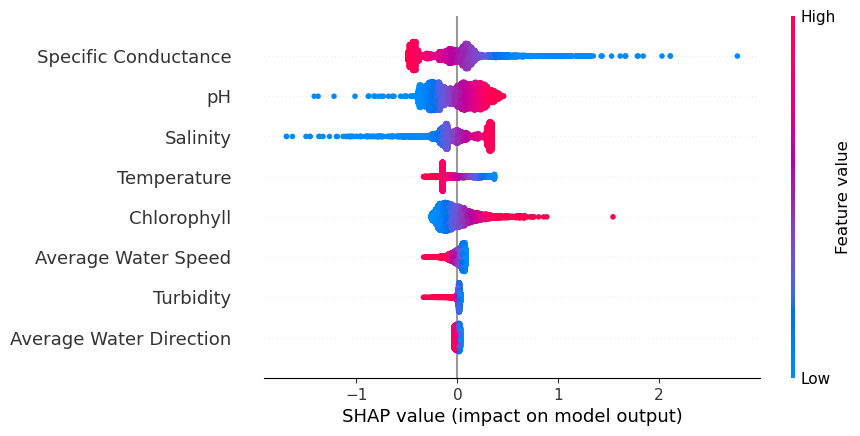

In [40]:
#Beeswarm
shap.plots.beeswarm(shap_values)

The beeswarm plot there by as shown above, tell us how a feature increses or decreases. If most red dots for "pH" are on the right, then high pH increases DO predictions. If they are on the left, hihg pH decreases DO.   

We have also visualized the ***Dependence Plot*** of each feature below inorder to see if the SHAP values of one feature changes differently at different values of another features. We chose to compare the top-5 features from the SHAP bar plot with eachother. The X-asis are the feature values while y-axis are SHAP values. 

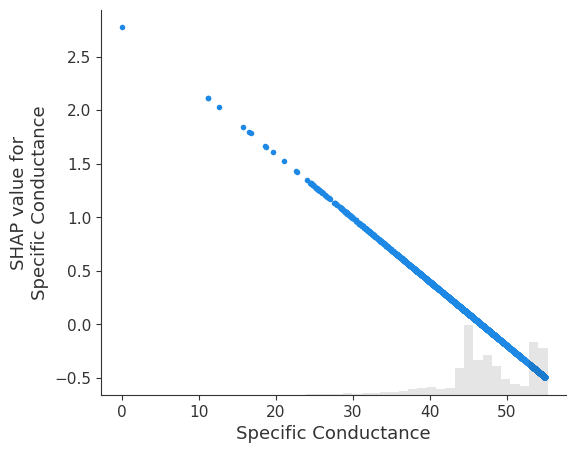

In [41]:
#Dependence Plot

#Specific Conductance
shap.plots.scatter(shap_values[:,'Specific Conductance'])

The plot above tell us that as Specific Conductance increases, the predicted DO decreases. Higher Specific Conductance -> Lower DO prediction. 

If we refer back to the bar plot earlier, this feature had the strongest overall impact on the model's output. However, with the impact being consistently negative. 

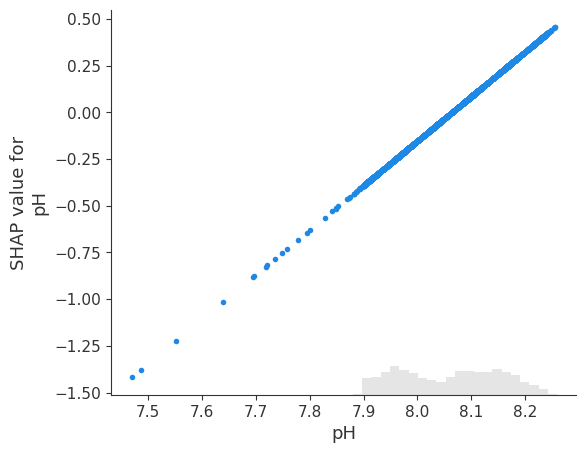

In [42]:
#pH
shap.plots.scatter(shap_values[:,'pH'])

The dependence plot above tell us that as pH increases, the SHAP value for pH increases as well. Which means that higher pH consistently increases the predicted DO level. 

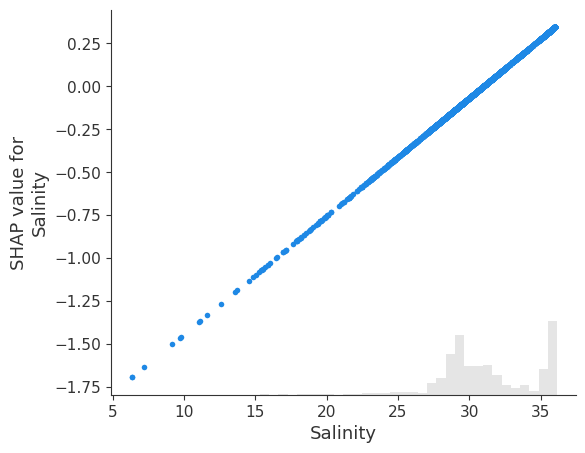

In [43]:
#Salinity
shap.plots.scatter(shap_values[:,'Salinity'])

This plot of Salinity above definitely suprised us, because apparently from what we read in ***Atlas Scientific***, as salinity increases, dissolved oxygen exponentially decreases. Because saltwater holds less oxygen than freshwater. While the plot above tells us an opposite story. 

Since the data is showing us a local trend, we assume that the salinity might correlate with other features in our samples. For instance cooler temperatures or higher pH/ chlorophyll which can increase DO. So the model might assign salinity a positive SHAP effect, even if its not the true driver.

- Source:
https://atlas-scientific.com/blog/dissolved-oxygen-and-salinity/ 

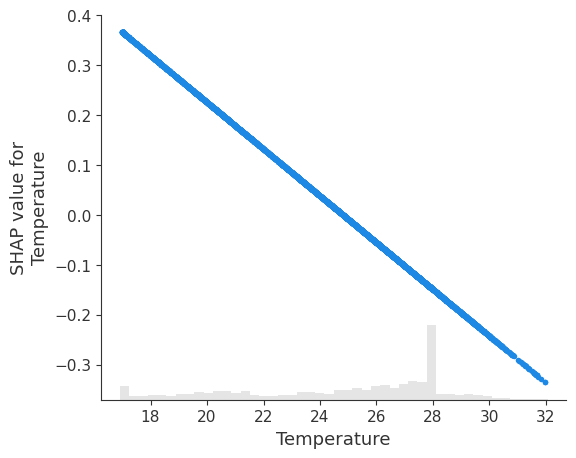

In [44]:
#Temperature 
shap.plots.scatter(shap_values[:,'Temperature'])

The plot above tells us that the temperature feature pulls predictions lower when it increases, across samples. According to ***Atlas Scientific***, oxygen solubility decreases with increasing temperatures.

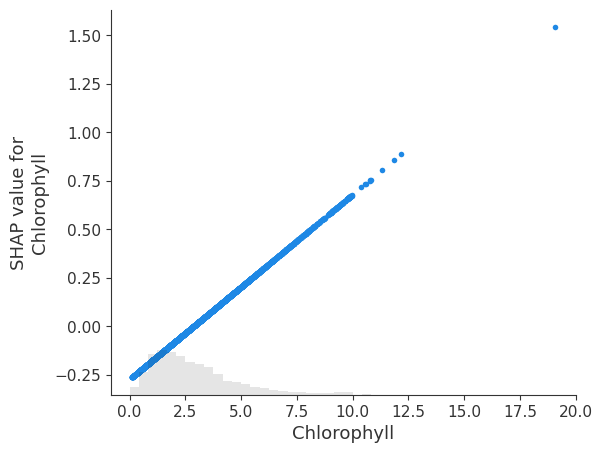

In [45]:
#Chlorophyll
shap.plots.scatter(shap_values[:,'Chlorophyll'])

This plot aligns with verified scientific sources aswell, which suggests that more chlorophyll increases DO. 

Chlorophyll is associated with algae and photosynthetic activity which leads more oxygen being produced, during daylight atleast. 

In order to understand the result of Dependence plot of Salinity, we wanted to use the color= shap_ values inorder to understand Salinity's interaction with other features. For instance, to check if Salinity increases because temperature is low. 

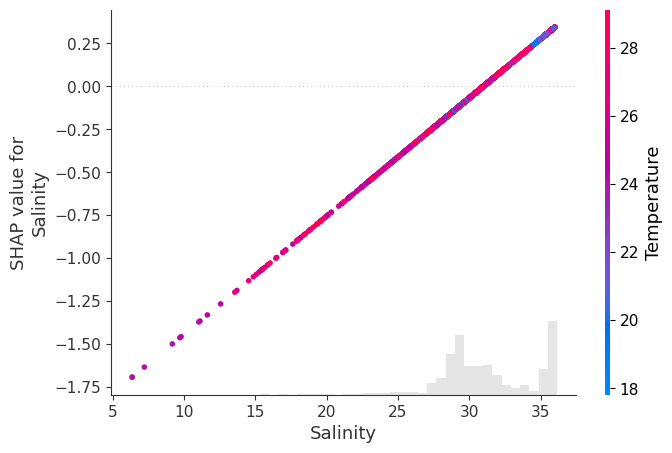

In [46]:
shap.plots.scatter(shap_values[:,"Salinity"], color=shap_values[:,"Temperature"])

The plot above is quite similar to the dependence plot, but it adds Temperature feature as the interaction color which reveals the relationship between Salinity and Temperature. 

The relationship between Salinity and SHAP value in linear as in the plot earlier with the color gradient also being evenly distributed along the line without distinct bands or curves. 

The effect of Salinity on DO prediction is roughly the same whether the water is warm or cool. It could be that the model learned that higher Salinity correlates with higher DO, and this trend holds across different temperatures. But we cant be sure until we check Salinity's interaction with other features. 

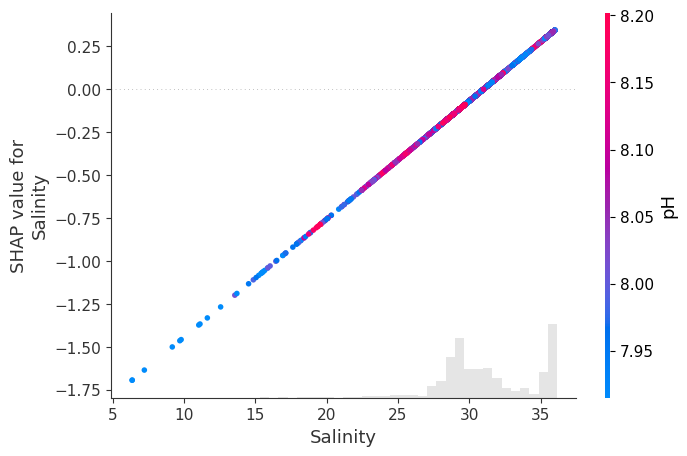

In [47]:
shap.plots.scatter(shap_values[:,"Salinity"], color=shap_values[:,"pH"])

We explored how pH might interact with Salinity when predicting dissolved oxygen (DO). The colors were evenly distributed, however salinity had a negative effect on DO predictions,when pH was lower (the blue color dots at the bottom). Which makes sense scitifically because pH levels can affect how aquatic systems handle gases like CO2 and O2 and higher pH is often a sign of active photosynthesis. 

So if pH is higher, there might be more oxygen in the water, which could reduce how strongly salinity pulls Do levels down. 

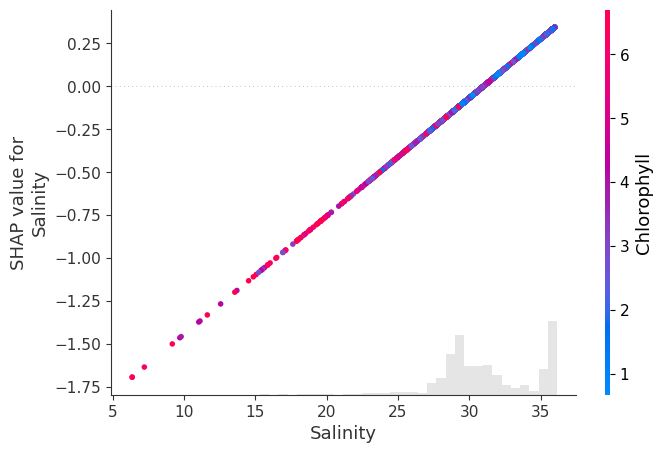

In [48]:
shap.plots.scatter(shap_values[:,"Salinity"], color=shap_values[:,"Chlorophyll"])

In the plot above, we ahve introduced Chlorophyll as an interaction feature in the SHAP dependence plot for Salinity. Since Higher Chlorophyll increased the DO predicitons, we wanted to check how the different levels were correlated with Sanity levels. 

Interestingly, we observed that the positive effect of Salinity weakened and in some case reversed when Chlorophyll levels were high. This suggests that while Salinity may be associated with higher DO in general, its effect is context-dependent. Specifically, in conditions with elevated Chrolophyll, Salinity may be contributing to lower DO predictions. 

Easily put: Salinity increased DO predictions, but for the samples where this happened, Chrolophyll levels were mostly low. While when Chrolophyll was high, Salinity`s positive effect was weaker or evn negative. 

However its also important to note that, there are also samples where the Salinity SHAP value was positive and the Chrolophyll was high. This suggest that our model doesnt apply hard rules, but is rather picking up multi-dimensional patterns

***Possible try outs***

Figure out if the LR model had a main role in detecting patterns which suggested that higher Salinity -> higher DO?

Group-level summary (bonus):

Try grouping samples by low/med/high Salinity

Compare mean DO levels or SHAP values of other features across those groups
➜ This could show indirect effects like:

##### Local Plots

Since our dataframe consists of 30000 samples, we might not be able to run check all the samples locally. However inorder to spot some strong influence or unexpected behavior, we chose to pick samples where DO is either very high or very low. 

In [49]:
#Predictions and Residuals 
y_pred = model_lr.predict(X_test)
residuals = np.abs(y_test.values - y_pred)

In [50]:
##Getting top samples with extreme predictions
#The argort sorts the predictions from low to high

top_preds = y_pred.argsort()[-5:][::-1]
low_preds = y_pred.argsort()[:5]

#Getting samples with highest prediction error
top_errors = residuals.argsort()[-5:]

#Finding samples where any features has very high SHAP impact
#We will look at the total SHAP values
shap_magnitude = np.abs(shap_values.values).sum(axis=1)
top_total_impact = shap_magnitude.argsort()[-5:]

#Combining all interesting sample indices
interesting_indices = set(top_preds) | set(low_preds) | set(top_errors) | set(top_total_impact)


In [51]:
#Define the groups
group_labels = {}

# Assign group labels to sample indices
for idx in top_preds:
    group_labels[idx] = group_labels.get(idx, []) + ["Highest DO Prediction"]

for idx in low_preds:
    group_labels[idx] = group_labels.get(idx, []) + ["Lowest DO Prediction"]

for idx in top_errors:
    group_labels[idx] = group_labels.get(idx, []) + ["Highest Prediction Error"]

for idx in top_total_impact:
    group_labels[idx] = group_labels.get(idx, []) + ["Most SHAP Influence"]

Sample index: 115 | Group: Lowest DO Prediction
Predicted DO: 5.71 | Actual DO: 4.66
Top contributing feature: pH (value: 7.801, SHAP: -0.628)

Waterfall plot for this sample:


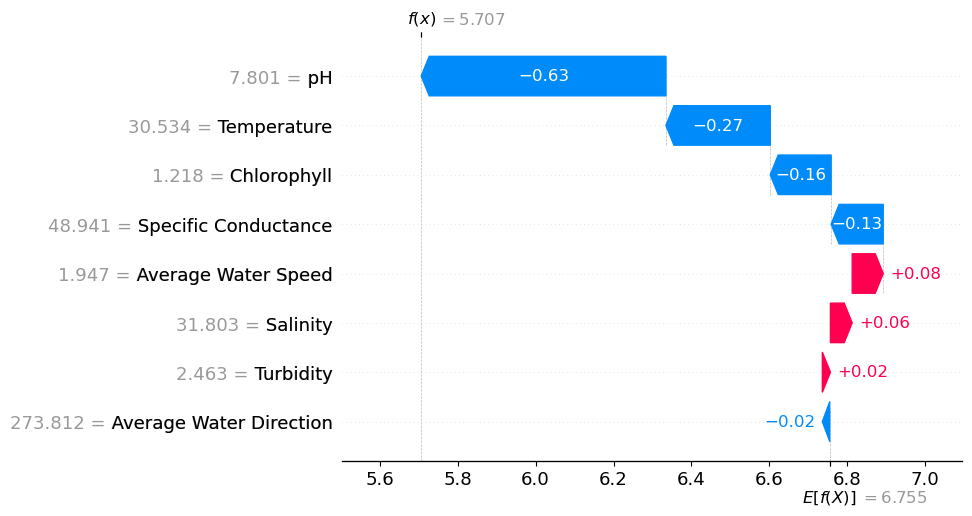

Sample index: 277 | Group: Highest DO Prediction
Predicted DO: 8.11 | Actual DO: 7.45
Top contributing feature: Chlorophyll (value: 9.015736263736263, SHAP: +0.586)

No waterfall plot shown for this sample, summary only.
Sample index: 446 | Group: Most SHAP Influence
Predicted DO: 6.48 | Actual DO: 7.88
Top contributing feature: Specific Conductance (value: 15.724, SHAP: +1.841)

No waterfall plot shown for this sample, summary only.
Sample index: 500 | Group: Highest DO Prediction, Most SHAP Influence
Predicted DO: 8.08 | Actual DO: 7.75
Top contributing feature: Specific Conductance (value: 19.565, SHAP: +1.613)

No waterfall plot shown for this sample, summary only.
Sample index: 871 | Group: Highest DO Prediction
Predicted DO: 8.23 | Actual DO: 7.93
Top contributing feature: Specific Conductance (value: 32.602, SHAP: +0.838)

No waterfall plot shown for this sample, summary only.
Sample index: 1274 | Group: Lowest DO Prediction
Predicted DO: 5.76 | Actual DO: 6.15
Top contributing 

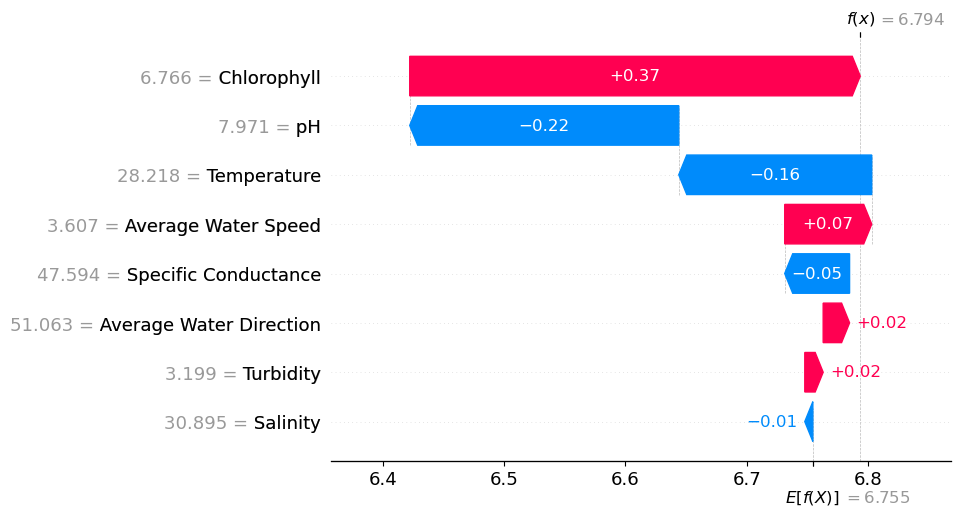

Sample index: 4462 | Group: Highest DO Prediction
Predicted DO: 8.27 | Actual DO: 7.91
Top contributing feature: Specific Conductance (value: 33.514625, SHAP: +0.784)

No waterfall plot shown for this sample, summary only.
Sample index: 4543 | Group: Most SHAP Influence
Predicted DO: 6.38 | Actual DO: 8.16
Top contributing feature: Specific Conductance (value: 11.201, SHAP: +2.110)

No waterfall plot shown for this sample, summary only.
Sample index: 4796 | Group: Highest Prediction Error
Predicted DO: 6.50 | Actual DO: 4.09
Top contributing feature: pH (value: 7.906428571428572, SHAP: -0.376)

No waterfall plot shown for this sample, summary only.
Sample index: 5203 | Group: Most SHAP Influence
Predicted DO: 6.00 | Actual DO: 8.00
Top contributing feature: Specific Conductance (value: 12.598, SHAP: +2.027)

No waterfall plot shown for this sample, summary only.
Sample index: 5360 | Group: Highest Prediction Error
Predicted DO: 6.63 | Actual DO: 3.99
Top contributing feature: pH (value

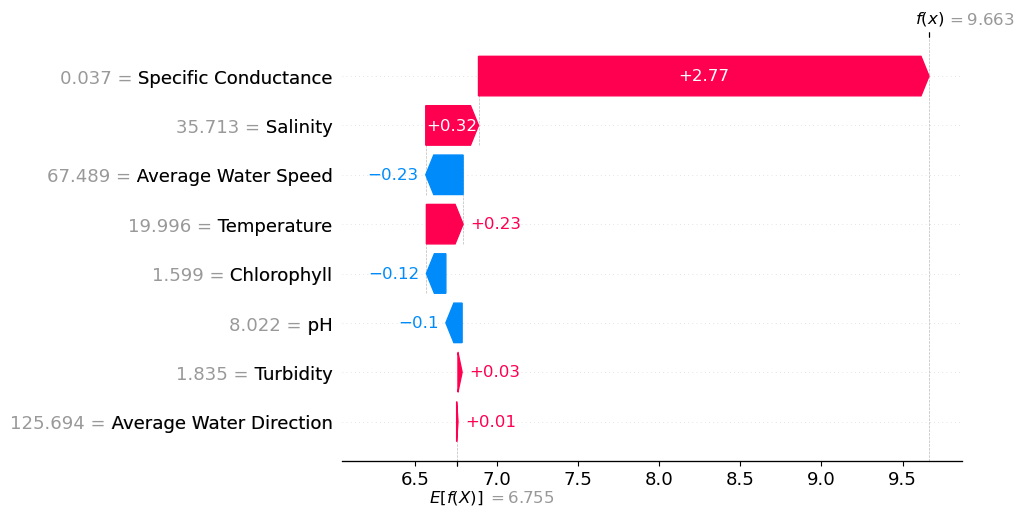

Sample index: 6110 | Group: Most SHAP Influence
Predicted DO: 6.23 | Actual DO: 8.16
Top contributing feature: Specific Conductance (value: 11.22, SHAP: +2.109)

No waterfall plot shown for this sample, summary only.


In [52]:
#Looping through and displaying one plot from each group, and summarizations of the rest.
plotted = {top_preds[0], low_preds[0], top_errors[-1]}  # show one key sample per group

for i in sorted(group_labels.keys()):
    group = ", ".join(group_labels[i])
    print(f"Sample index: {i} | Group: {group}")
    print(f"Predicted DO: {y_pred[i]:.2f} | Actual DO: {y_test.values[i]:.2f}")

    top_feat_idx = np.argmax(np.abs(shap_values.values[i]))
    top_feat_name = X_test.columns[top_feat_idx]
    top_feat_value = X_test.iloc[i][top_feat_name]
    top_feat_shap = shap_values.values[i][top_feat_idx]

    print(f"Top contributing feature: {top_feat_name} (value: {top_feat_value}, SHAP: {top_feat_shap:+.3f})")
    print("")

    if i in plotted:
        print("Waterfall plot for this sample:")
        shap.plots.waterfall(shap_values[i])
    else:
        print(f"No waterfall plot shown for this sample, summary only.")


Compare two similar samples with different predictions
"Why did these two water samples get different DO predictions?"

#### ***Linear Regression with Coefficients***

In [53]:
coef_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": model_lr.coef_}).sort_values("Coefficient",ascending=False)
print(coef_df)

                   Feature  Coefficient
4                       pH     2.387606
2              Chlorophyll     0.095130
5                 Salinity     0.068781
1  Average Water Direction    -0.000182
0      Average Water Speed    -0.004723
7                Turbidity    -0.007607
3              Temperature    -0.046856
6     Specific Conductance    -0.059451


In [54]:
#Comparing the results above to SHAP global values
#This can tell us whether SHAP and coefficients agree on certain things

coef_df["mean(|SHAP|)"] = np.abs(shap_values.values).mean(axis=0)
coef_df = coef_df.sort_values("mean(|SHAP|)", ascending=False)


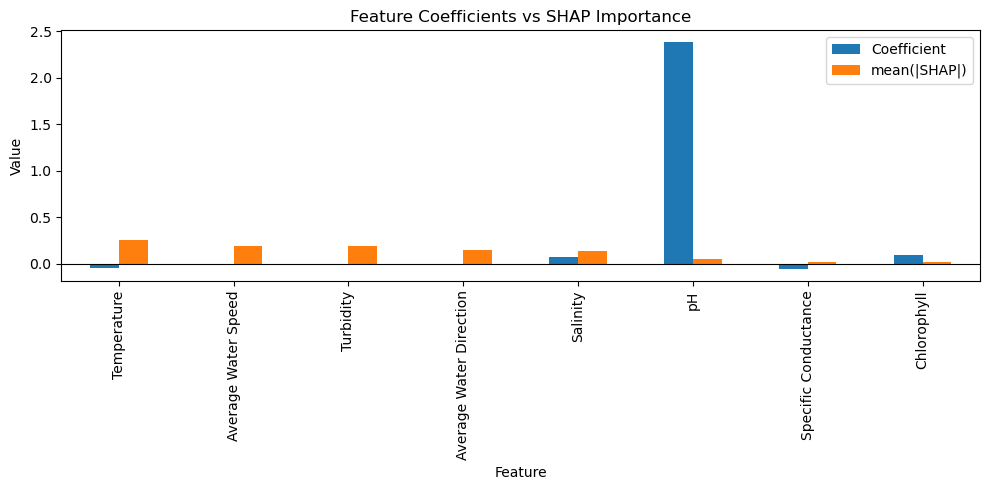

In [55]:
#Visualizing the comparisions
import matplotlib.pyplot as plt

#Plot
coef_df.set_index("Feature")[["Coefficient", "mean(|SHAP|)"]].plot(
    kind="bar", figsize=(10, 5), title="Feature Coefficients vs SHAP Importance"
)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Value")
plt.tight_layout()
plt.show()


#### ***Linear Regression with PDP***

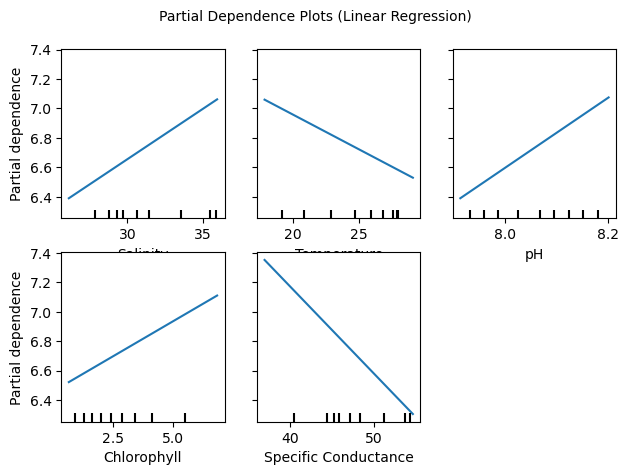

In [56]:
from sklearn.inspection import PartialDependenceDisplay

#Picking top-5 features to analyze, for example based on SHAP global bar
features_to_plot = ["Salinity", "Temperature", "pH", "Chlorophyll", "Specific Conductance"]

PartialDependenceDisplay.from_estimator(
    model_lr, X_train, features=features_to_plot, grid_resolution=50
)

plt.suptitle("Partial Dependence Plots (Linear Regression)", fontsize=10)
plt.tight_layout()
plt.show()


#### Random Forest Regressor

#### ***Random Forest and SHAP***

To interpret the predictions of our Random Forest model, we use SHAP (Shapley Additive Explanations). SHAP helps us understand which features most influence the model's predictions, both globally (across all samples) and locally (for individual predictions).

Because computing SHAP values for large datasets can be slow, we use a random sample of 200 rows from the training data. Which provides a good balance between speed and interpretability.

- **Global summary plot:** Shows the overall importance and effect of each feature on the model's predictions.
- **Local waterfall plot:** Explains the prediction for a single sample, showing how each feature contributed to the final prediction.

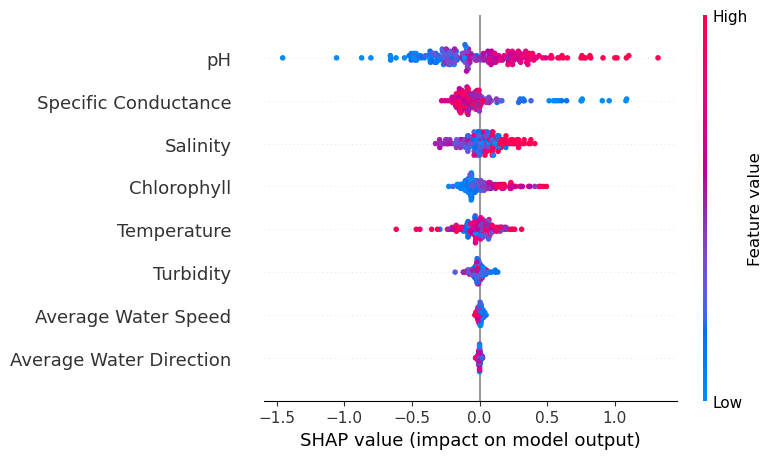

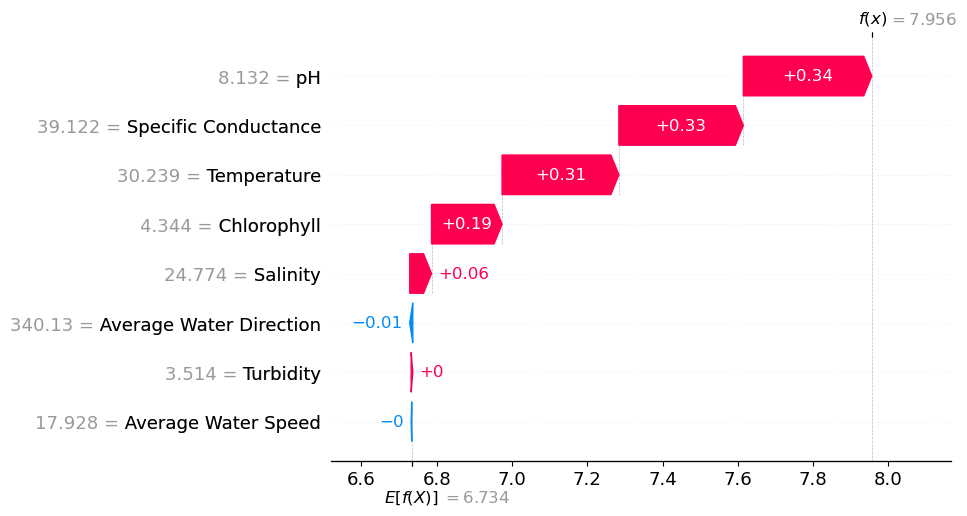

In [57]:
# Compute and plot SHAP values for Random Forest (using a sample for speed)
import shap

# Take a random sample of 200 rows from X_train for faster computation
X_sample = X_train.sample(200, random_state=42)

# Create SHAP explainer for the fitted Random Forest model
explainer = shap.TreeExplainer(model_rfr)

# Compute SHAP values as Explanation objects (new API)
shap_values_rfr = explainer(X_sample)

# Global summary plot
shap.summary_plot(shap_values_rfr, X_sample)

# Local explanation for a single sample
shap.plots.waterfall(shap_values_rfr[0])

#### ***Random Forest and PDP***

#### Partial Dependence Plots: Feature Impact on Dissolved Oxygen
Partial Dependence Plots (PDP) below illustrate how changes in each feature affect the model's predicted Dissolved Oxygen, holding other features constant.

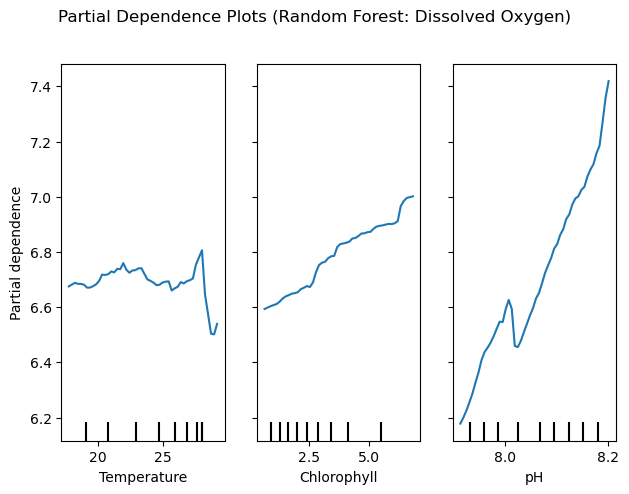

In [58]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Define features to plot
pdp_features = ['Temperature', 'Chlorophyll', 'pH']

# Create Partial Dependence Plots for Random Forest model
PartialDependenceDisplay.from_estimator(
    model_rfr,
    X_train,
    pdp_features,
    grid_resolution=50,
    n_jobs=-1
)

plt.suptitle("Partial Dependence Plots (Random Forest: Dissolved Oxygen)", y=1.02)
plt.tight_layout()
plt.show()

#### ***XGB-Boost with SHAP***

To better understand how dissolved oxygen (DO) levels can be predicted, we trained an XGBoost model using not only the current water measurements, but also lagged DO values from previous time steps. The idea was to see if knowing past oxygen levels helps the model make better predictions about the present. 

Using SHAP and other XAI tools, we focused on finding out how important these lag features were compared to the regular features. This could help us figure out whether the model is mainly relying on real-time environmental conditions, or if its also picking up patterns over time where past oxygen levels play a big role. The results give us a deeper view of what influences DO predictions and whether inlcuding time-based information actually makes a meaningful difference. 

In [59]:
#Since XGB-boost is a tree based model, it does not require background data like X_train in shap.Explainer(), like we did earlier with Linear Regression
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test_xgb)

#### Global Plots

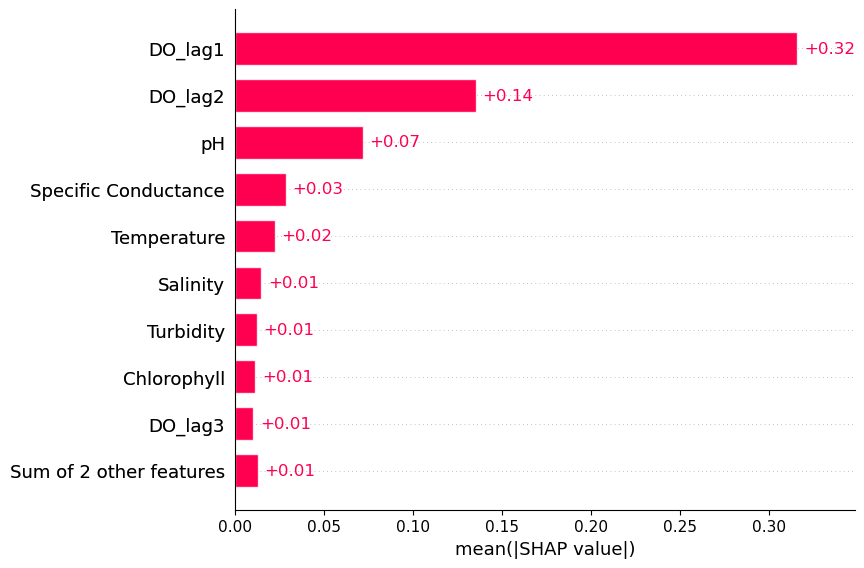

In [60]:
#Bar plot
shap.plots.bar(shap_values)

***XGBoost Comparision with Linear Regression (SHAP bar plot)***
- The SHAP plot above tell us that the XGBoost model heavility relies on DO_lag1 and DO_lag2, with everything else a little far behind. While for Linear Regression, the top feature are Specific Conducantance, pH, Salinity, Temperature etc. For XGBoost, since we gave the past DO values, it mostly remembers the past to make predictions, while environmental features become less important.

- While in Linear Regression, Salinity had -0.18 SHAP impact, In XGBoost however, it drops to -0.01. We assume that due to Linear Regression's simplistic and linear nature, it might have overemphasized salinity earlier. When XGBoost, being more flexible probably have learned that salinity alone doesnt help much when past DO is known. 

- There are also features which are relatively important in both models

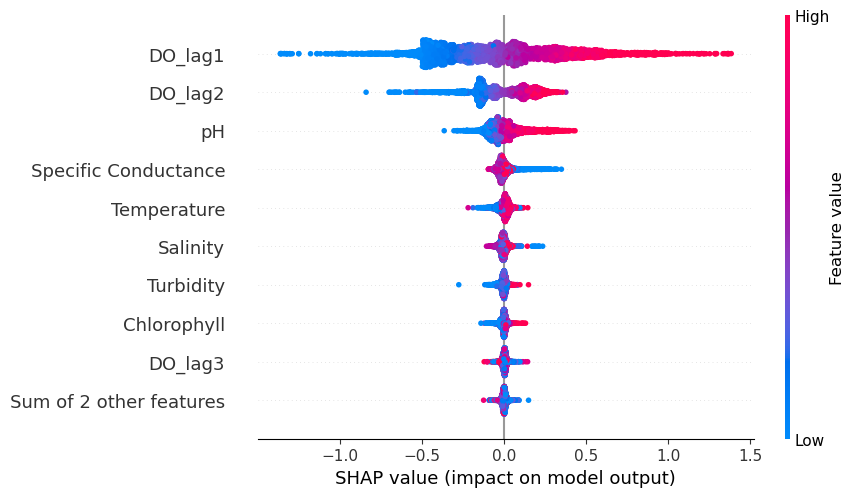

In [61]:
#Beeswarm
shap.plots.beeswarm(shap_values)

Since we included lagged DO features (previous DO levels) as inputs for the XGBoost model, it naturally prioritized these lag features because they offer a strong, direct signal for predicting current DO. 

Without lag features, the model would have had to rely much more heavily on real-time environemental measurements like pH, Salinity and Temperature etc as in Linear regression and Random Forest earlier. This shows that including short-term memory significantly changes what the model "pays attention to" when making predictions. 

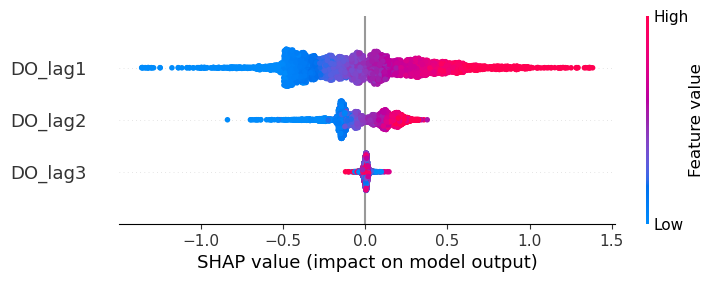

In [62]:
#Plotting SHAP values for lag features only
lag_features =[col for col in X_test_xgb.columns if 'DO_lag' in col]

lag_shap_values =shap_values[:,lag_features]

shap.plots.beeswarm(lag_shap_values,max_display=5)


The plot above is only filtered to show DO_lag1, DO_lag2 and DO_lag3. We can see that DO_lag1 has the biggest spread and strongest influence, while DO_lag3 has very small shap values around 0, vert little influence. 

This results might imply that, the most recent past (DO_lag1) is very useful, DO_lag2 add a little more help, and 3-step memory (DO_lag3) almost doesnt matter for current predictions. 

#### Local Plots

Instead of only focusing on extreme predictions, we selected samples across the full range of predicted dissolved oxygen levels (low,medium and high). This gives us a more balanced and representative view of how the model makes predictions.

In [63]:
#Predicted DO values
y_pred = model_xgb.predict(X_test_xgb)

#Finding percentiles
low_thresh = np.percentile(y_pred, 25)
high_thresh = np.percentile(y_pred, 75)

#Picking the indices
low_indices = np.where(y_pred <= low_thresh)[0]
mid_indices = np.where((y_pred > low_thresh) & (y_pred < high_thresh))[0]
high_indices = np.where(y_pred >= high_thresh)[0]

#Sampling 3 from each group randomly
np.random.seed(42)
chosen_low = np.random.choice(low_indices, size=3, replace=False)
chosen_mid = np.random.choice(mid_indices, size=3, replace=False)
chosen_high = np.random.choice(high_indices, size=3, replace=False)

#Merging all the selected indices
selected_samples = list(chosen_low) + list(chosen_mid) + list(chosen_high)


In [65]:
#Creating a dictionary which maps sample indices to their groups for a clearer visuals 
sample_group = {}

for i in chosen_low:
    sample_group[i] = "Low DO group"

for i in chosen_mid:
    sample_group[i] = "Medium DO group"

for i in chosen_high:
    sample_group[i] = "High DO group"

***How to analyze the plots and sample groups below:***

✅ Check This	            
1. Top contributing features. Which features pushed the    prediction up or down the most?
2. Is DO_lag1 dominating every time? Does the model always rely mostly on recent DO? Or only for high/low?
3. What differs across groups?	Do low DO samples have different driving features than high DO ones?
4. Direction of influence	For each feature: is it increasing or decreasing the prediction?
5. Environmental feature involvement	Are things like pH, Salinity, or Temperature showing up more in some groups than others?
6. Surprising or unexpected pushes?	Any feature you didn’t expect to be important in that sample?


Sample index: 2514 | Group: Low DO group
Predicted DO: 6.13
Actual DO: 6.24


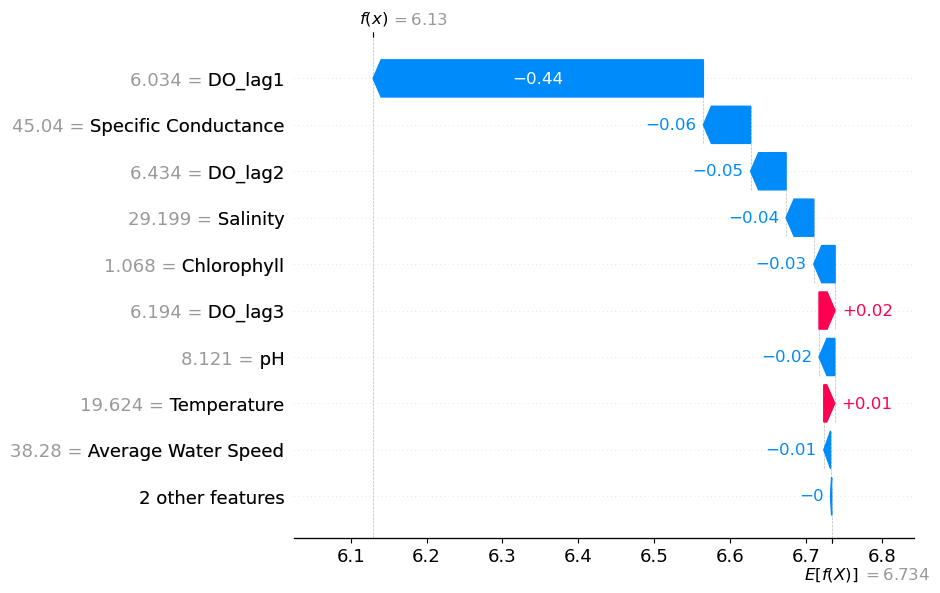

Sample index: 353 | Group: Low DO group
Predicted DO: 5.69
Actual DO: 5.64


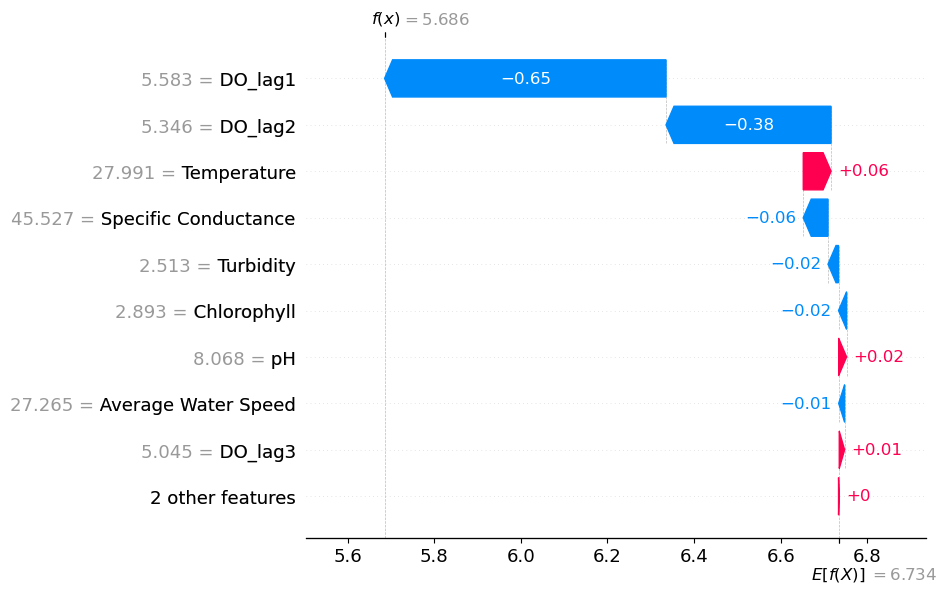

Sample index: 1212 | Group: Low DO group
Predicted DO: 6.10
Actual DO: 6.08


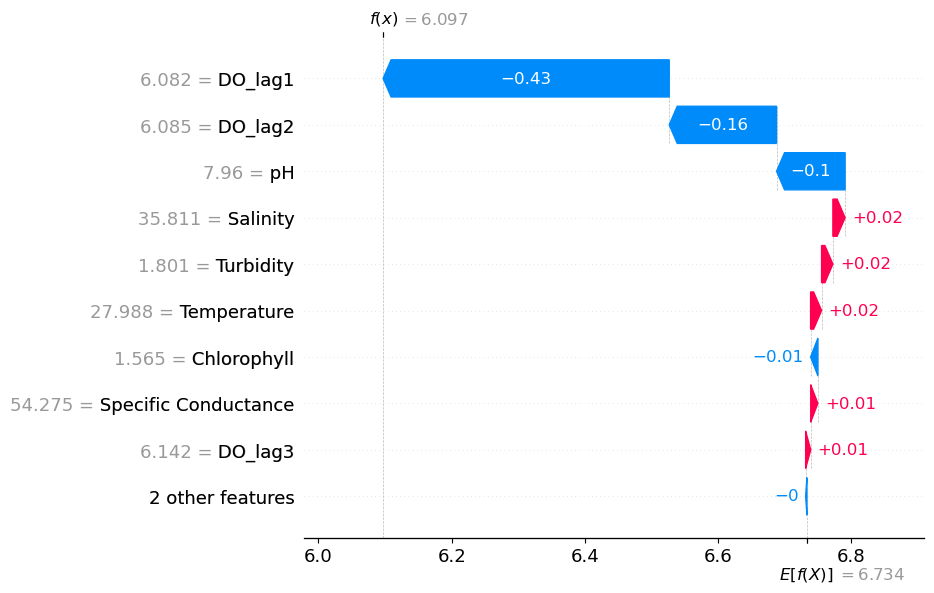

Sample index: 691 | Group: Medium DO group
Predicted DO: 6.43
Actual DO: 7.01


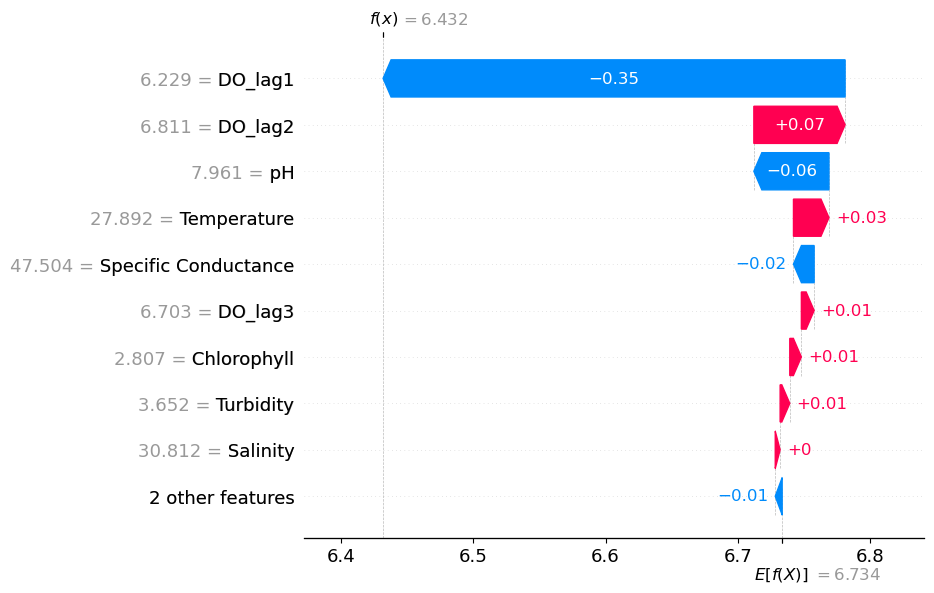

Sample index: 661 | Group: Medium DO group
Predicted DO: 6.96
Actual DO: 7.00


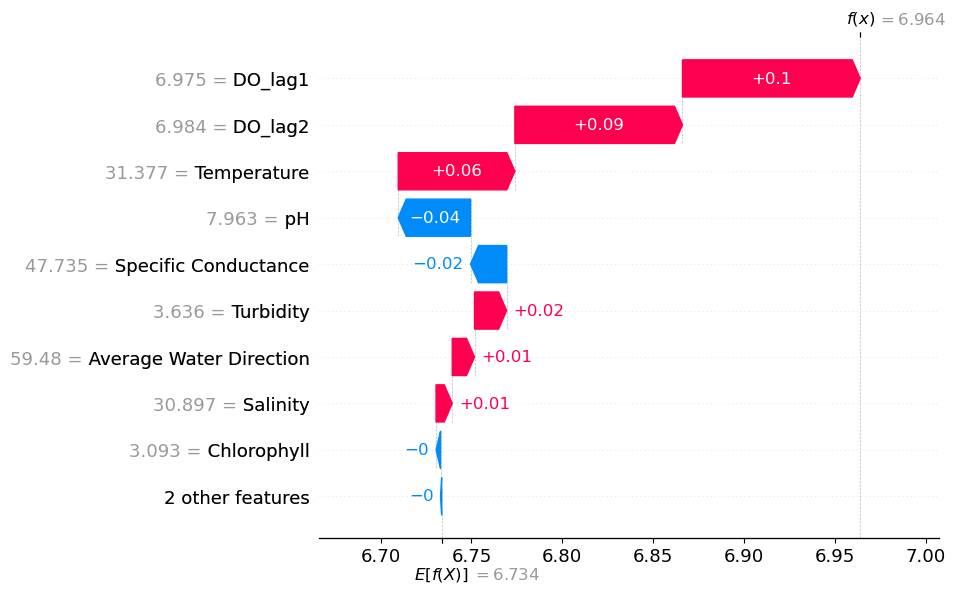

Sample index: 2064 | Group: Medium DO group
Predicted DO: 6.78
Actual DO: 6.79


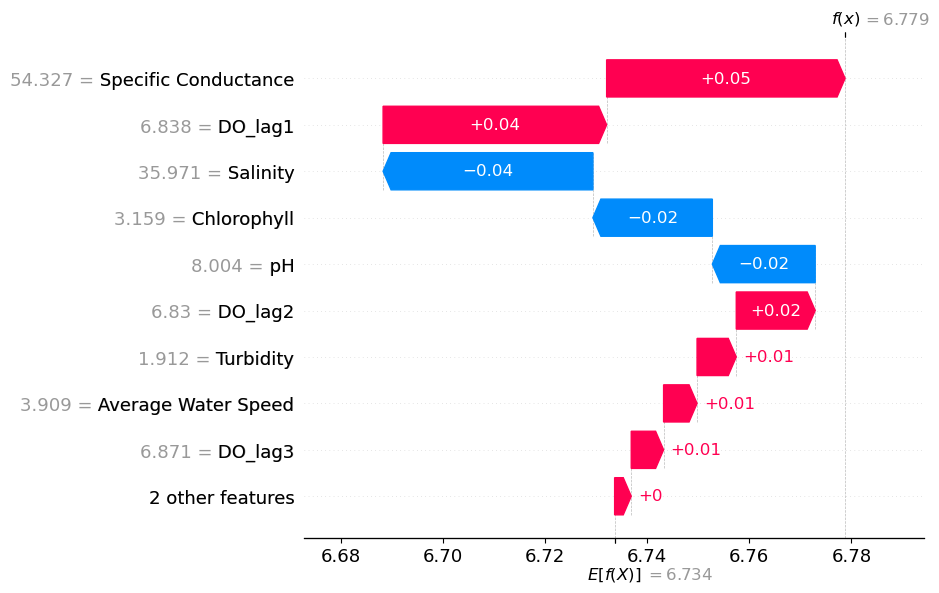

Sample index: 656 | Group: High DO group
Predicted DO: 7.16
Actual DO: 7.28


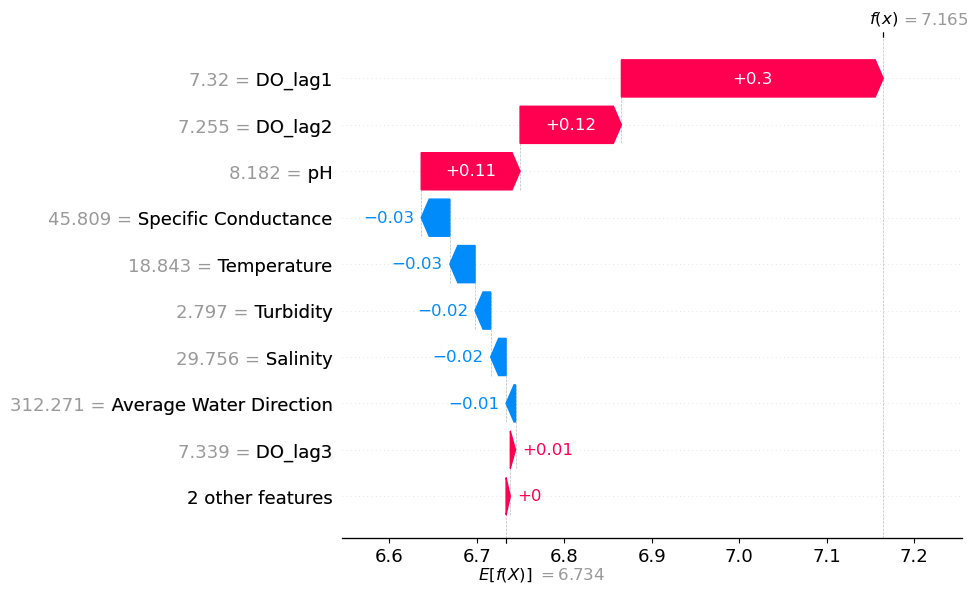

Sample index: 5764 | Group: High DO group
Predicted DO: 7.40
Actual DO: 7.24


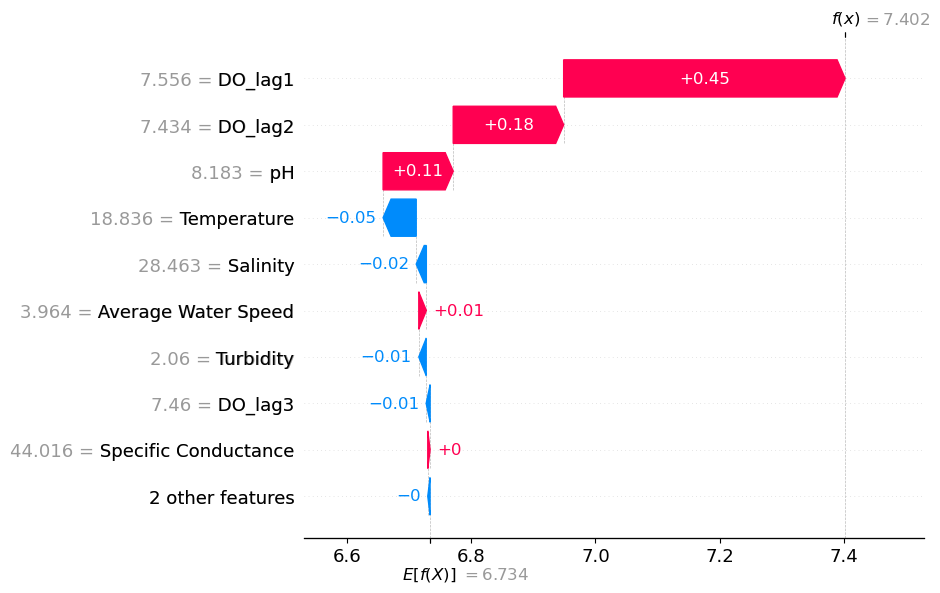

Sample index: 3049 | Group: High DO group
Predicted DO: 7.69
Actual DO: 7.72


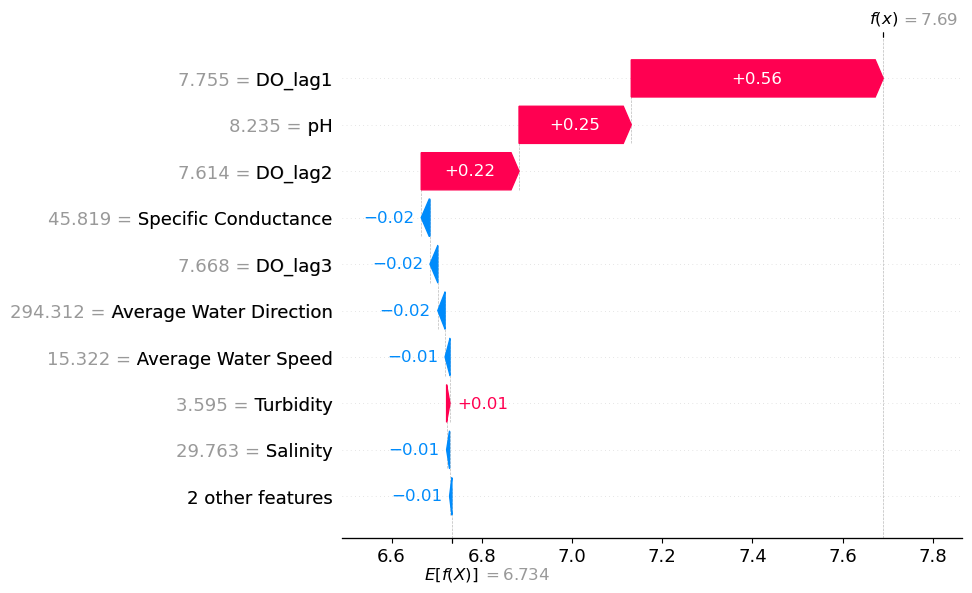

In [ ]:
#Waterfall plots for selected XGBoost samples

for i in selected_samples:
    #Fallback for just in case
    group = sample_group.get(i, "Uknown Group")

    print(f"Sample index: {i} | Group: {group}")
    print(f"Predicted DO: {model_xgb.predict(X_test_xgb.iloc[[i]])[0]:.2f}")
    print(f"Actual DO: {y_test.iloc[i]:.2f}")
    
    shap.plots.waterfall(shap_values[i])


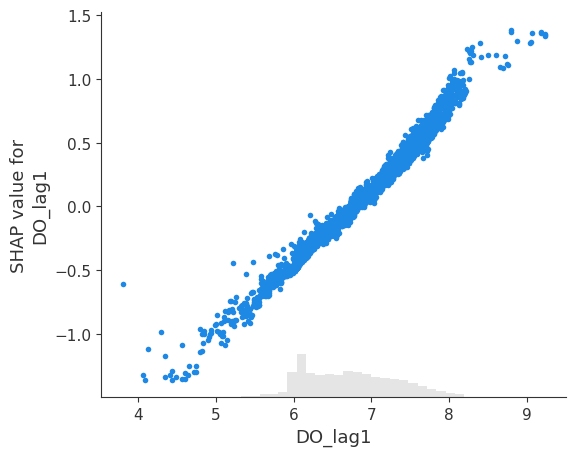

In [81]:
#Dependence Plot 
shap.plots.scatter(shap_values[:, "DO_lag1"])

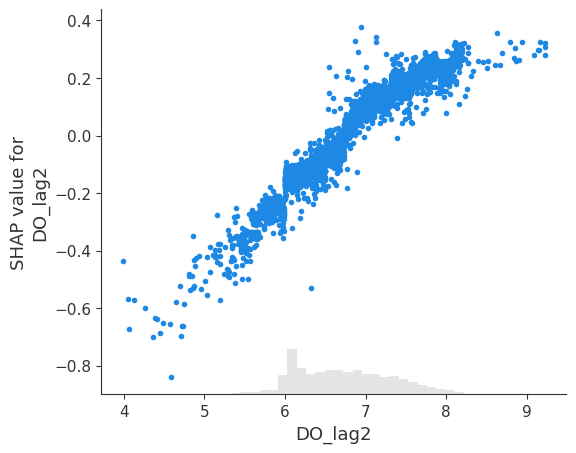

In [82]:
#Dependence Plot 
shap.plots.scatter(shap_values[:, "DO_lag2"])

For DO_lag1 dependence plot, we can see that the SHAP values go from about below -1.0 to +1.5. We can also see a clear linear relationship which indicates that higher recent DO strongly increases the predicted DO level. 

The DO_lag2 dependence plot on the other hand, follows an upward trend, but is a little weaker. The SHAP values range from about -0.8 to +0.4. However, we think that this feature is less consistent and strong compared to DO_lag2, which was also shown in the global SHAP plots earlier. 

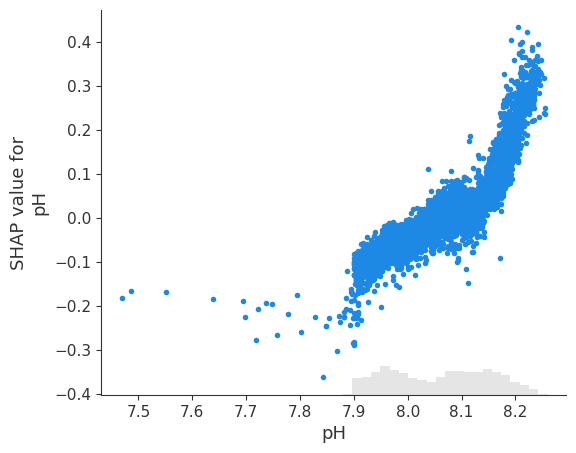

In [83]:
#Dependence Plot 
shap.plots.scatter(shap_values[:, "pH"])

In the pH dependence plot above, we can see that higher pH leads to higher predicted DO, but the relationship nonlinear. Below 7.9 ph pushses the predictions down, while the samples beyond 8.0, strongly push the predictions up. This pattern makes scientifically sense, as higher pH can be linked to more photosynthesis and oxygenation in water (SOURCE). 

In both linear and XGBoot models, higher pH values were associated with increased DO predictions. However, the XGBoost dependence plot revealed a non-linear pattern where pH had mininal or even negative impact at lower valies but began stringly boosting predictions above a threshold. This might suggest that the black-box model was able to capture more realistic interactions. 

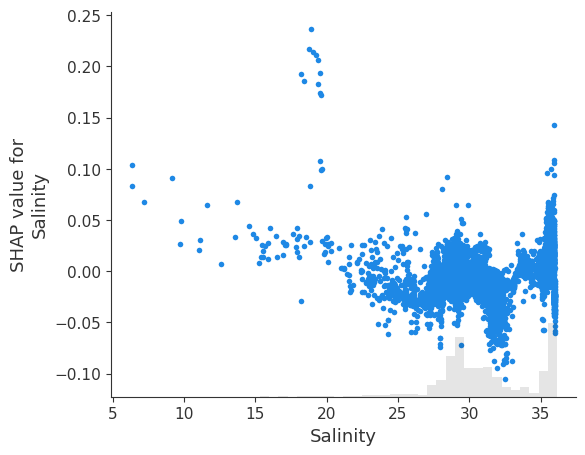

In [79]:
#Dependence Plot 
shap.plots.scatter(shap_values[:, "Salinity"])

Most SHAP values in the plot above are close to 0, which may imply that Salinity has weak influence across most samples, overall. 

Specifically, around salinity 20 to 30, SHAP values dip slightly below 0, which may suggest that, higher salinity decreases predicted DO. There are also some positive SHAP values at low salinity <10 and very high salinty >35. Howeever, we assume that it can be possible noise or limited examples. 

The dependence plot for Salinity in the XGBoost model showed that its SHAP values remained close to 0 across most Salinity levels, indicating a weak influence on DO predictions. This contrasts with the Linear Regression model, where Salinity had a strong positive effect. The difference suggests that once lagged DO values are introduced, the model no longer relies on salinity as a predictive signal, which might reveal a potential overemphasis in the simpler linear model.

#### Time Series with SHAP plot

In [73]:
#Since there were a few important features according to bar plot, we wish to however choose the top-3 most interesting ones. 

#Extracting SHAP values for each feature as arrays
shap_lag1 = shap_values[:, "DO_lag1"].values
shap_lag2 = shap_values[:, "DO_lag2"].values
shap_ph   = shap_values[:, "pH"].values

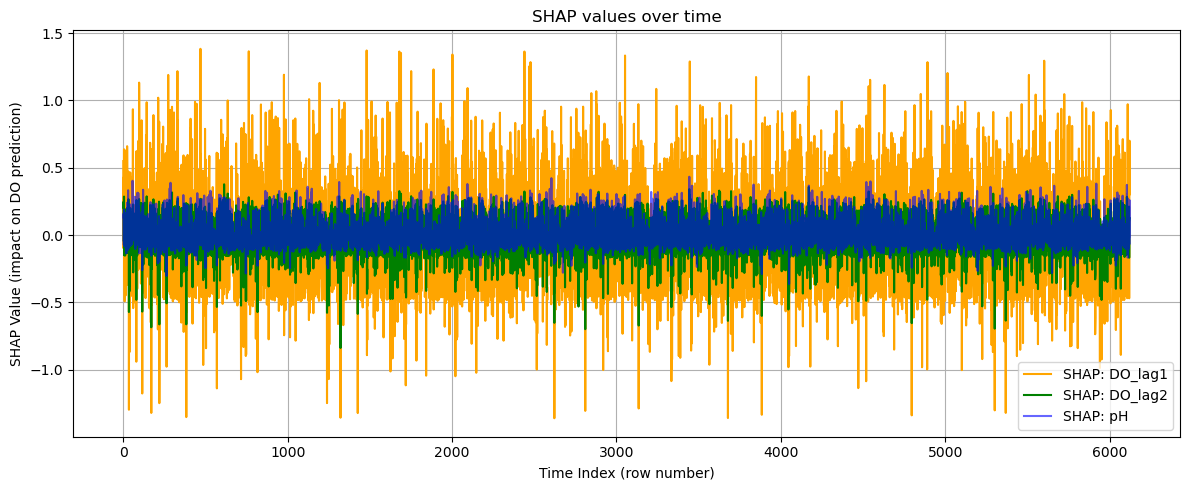

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.plot(shap_lag1, label="SHAP: DO_lag1", color="orange")
plt.plot(shap_lag2, label="SHAP: DO_lag2", color="green")
plt.plot(shap_ph, label="SHAP: pH", color="blue", alpha=0.6)  # Optional

plt.title("SHAP values over time")
plt.xlabel("Time Index (row number)")
plt.ylabel("SHAP Value (impact on DO prediction)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The results from Time-Series plot above show us that the SHAP value for DO_lag1 (orange line) swing much more strongly (both positive and negative). While DO_lag2 (green line) has much narrower range of SHAP values compared to DO_lag1, however this feature adds value but doesnt seem to shift predictions dramatically. The SHAP value for pH is thereby clustered tighly aroound 0. The effect is much weaker and consistent over time. pH contributes, but the model does not seem to rely heavily on it at any particular point in time. 

Overall, the model seems to rely most heavily on the most recent dissolved oxygen value (DO_lag1) over time, in order to make predictions. 



#### XGBoost and PDP

In [75]:
from sklearn.inspection import PartialDependenceDisplay

In [77]:
#Picking the top features based on the  global results earlier 
features = ["DO_lag1", "DO_lag2", "pH", "Temperature", "Salinity"]

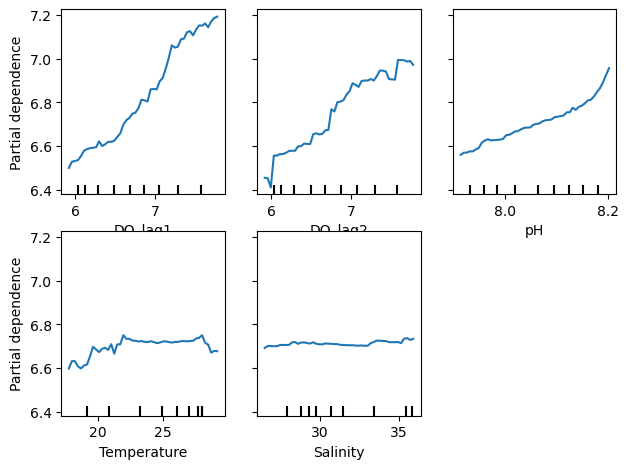

In [78]:
PartialDependenceDisplay.from_estimator(
    model_xgb,      
    X_test_xgb,          
    features,        
    kind="average",  
    n_jobs=-1,      
    grid_resolution=50,  
)

plt.tight_layout()
plt.show()

Paritial Dependence Plots (PDPs) were used to understand the average effect of individual features on predicted DO values.